# Policy-based Agent using PyTorch

In [1]:
import time
import torch
import imageio
import gymnasium as gym
import matplotlib.pyplot as plt

from agents import PolicyGradientAgent

## Environments

### Cart-pole

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

#### Training

In [3]:
GAMES = 10000
AGENT = PolicyGradientAgent(inputs=4, outputs=2)

In [4]:
checkpoint = GAMES // 10
metrics = {"steps": torch.zeros(GAMES), "gradients": torch.zeros(GAMES)}

In [5]:
start = time.time()
for game in range(1, GAMES + 1):
    
    observation = torch.tensor(environment.reset()[0], dtype=torch.float32)  # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # --------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action, logarithm = AGENT.action(observation)
        observation, reward, terminated, truncated, _ = environment.step(action)
        observation = torch.tensor(observation, dtype=torch.float32)
        AGENT.memorize(logarithm, reward)
    gradient = AGENT.learn()
    
    # METRICS
    # --------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["gradients"][game-1] = gradient
    
    if game % checkpoint == 0 or game == GAMES:

        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_gradient = metrics["gradients"][max(0, game-checkpoint-1):game-1].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average gradients: {_mean_gradient:>8.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game   1000               10 % 
------------------------------ 
 > Average steps:           51 
 > Average gradients:  -0.4995 
 
Game   2000               20 % 
------------------------------ 
 > Average steps:          210 
 > Average gradients:  -2.4626 
 
Game   3000               30 % 
------------------------------ 
 > Average steps:          383 
 > Average gradients:  -3.7951 
 
Game   4000               40 % 
------------------------------ 
 > Average steps:          461 
 > Average gradients:  -4.0131 
 
Game   5000               50 % 
------------------------------ 
 > Average steps:          478 
 > Average gradients:  -3.6548 
 
Game   6000               60 % 
------------------------------ 
 > Average steps:          485 
 > Average gradients:  -1.7382 
 
Game   7000               70 % 
------------------------------ 
 > Average steps:          485 
 > Average gradients:  -2.5535 
 
Game   8000               80 % 
------------------------------ 
 > Average steps:         

##### Visualisation

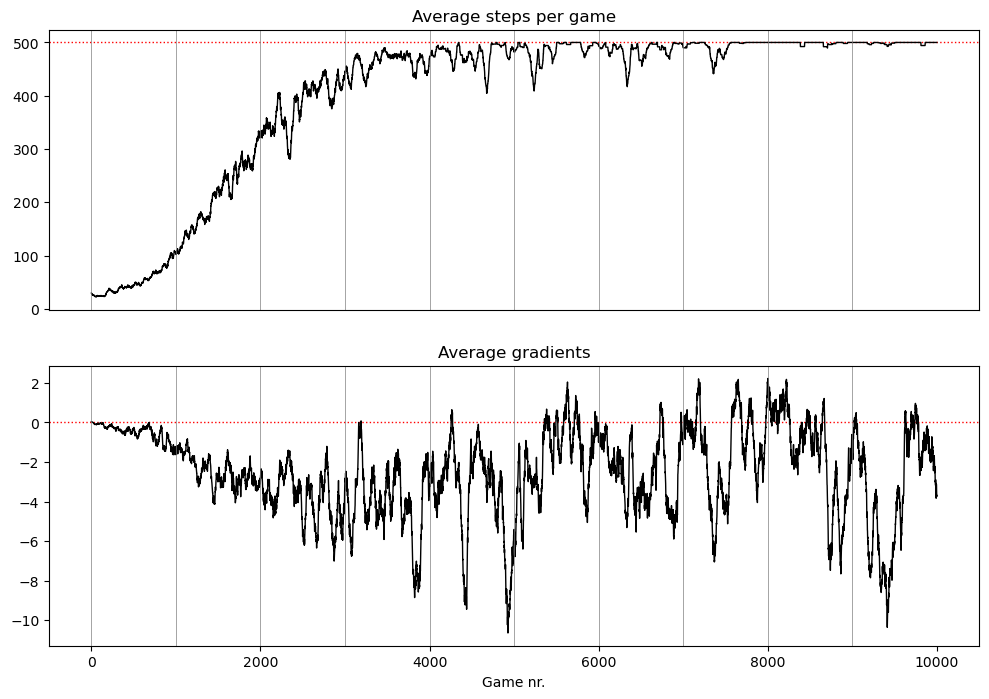

In [6]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(GAMES, i+half_window)]).mean() 
            for i in range(GAMES)]

steps = moving_average(metrics["steps"])
gradients = moving_average(metrics["gradients"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].axhline(y=500, color="red", linestyle="dotted", linewidth=1)
ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].axhline(y=0, color="red", linestyle="dotted", linewidth=1)
ax[1].plot(gradients, color="black", linewidth=1)
ax[1].set_xlabel("Game nr.")
ax[1].set_title("Average gradients")

for i in range(0, GAMES, 1000):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)

plt.show()

#### In action

In [7]:
observation = torch.tensor(environment.reset()[0], dtype=torch.float32)

images = []
terminated = truncated = False
while not (terminated or truncated):
    actions = torch.softmax(AGENT(observation), dim=-1)
    action = torch.argmax(actions).item()
    
    observation, reward, terminated, truncated, _ = environment.step(action)
    observation = torch.tensor(observation, dtype=torch.float32)

    images.append(environment.render())
_ = imageio.mimsave('./figures/policy-based-gradient.gif', images, duration=25)

<img src="./policy-based-gradient.gif" width="400" height="400" />

In [8]:
environment.close()